<a href="https://colab.research.google.com/github/explcre/pipeDejavu/blob/main/auto_pipeline_slicing_dp_ipynb-copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# Define a simple input tensor with 7 elements
x = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], requires_grad=True)

# Apply the max operation on the input tensor
max_value, max_idx = torch.max(x,dim=0)

# Define the loss function as the max value
loss = max_value

# Compute the gradients
loss.backward()

# Print the gradients with respect to the input tensor
print("Gradients: ", x.grad)


Gradients:  tensor([0., 0., 0., 0., 0., 0., 1.])


In [ ]:
!pip install numba


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install cupy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cupy-12.0.0.tar.gz (2.0 MB)
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 241, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 463, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 347, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 221, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.10/dist-packages/pip/_i

In [36]:
import copy
import itertools
import time
import math
import numpy as np
import cupy as cp
from numba import jit, prange

In [ ]:
!nvidia-smi

Sun May  7 03:19:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# simplification
def f(L, maxl, cost, k, B):
    if k == 1:
        return ([L], B*max(0, L-maxl))
    if k == L:
        cost_ = max(1, maxl) * B
        for i in range(k-1):
         #   cost_ += cost[i][i]
            cost_ += cost[i]
        return ([1] * L, cost_)
    
    cost_best = float("inf")
    S_best = []
    for i in reversed(range(k, L)):
        S, cost_ = f(i, max(L-i, maxl), cost, k-1, B)
        cost_ += max(0, L-i-maxl)*B
        cost_ += cost[i-1]
        if cost_ < cost_best:
            cost_best = cost_
            S.append(L-i)
            S_best = S
    return S_best, cost_best

In [ ]:
L = 12
k = 8
cost = [2,1,1,3] * 12
f(L, 0, cost, k, 3)

([2, 1, 2, 2, 2, 1, 1, 1], 15)

In [35]:
#@jit(nopython=True)
def pipe_dp(L, cost_e, cost_c, k, B):
    # Generate all possible max length
    possible = [0]
    
    for i in range(1, L+1):
        ptr = 0
        while ptr + i <= L:
            possible.append(sum(cost_e[ptr:ptr+i]))
            ptr += 1
    
    possible = sorted(list(set(possible)))
    # print(possible)
    # trace will be a 3D list
    trace = []
    for i in range(L):
        outer = []
        for j in range(k):
            inner = []
            for m in range(len(possible)):
                inner.append(([],np.infty))
            outer.append(inner)
        trace.append(outer)
    
    # i: layer id, starting from 0
    # j: number of cut (=GPU-1)
    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                if i+1 <= j: # invalid
                    pass
                else:
                    if j == 0: # base case: 0 cut
                        cur_sum = sum(cost_e[:i+1])
                        assert cur_sum in possible
                        trace[i][j][m] = ([i+1], (B-1) * max(0, cur_sum - possible[m]))
                    else:
                        cost_best = np.infty
                        S_best = []
                        for cut in range(j-1, i):
                            cur_sum = sum(cost_e[cut+1:i+1])
                            assert cur_sum in possible
                            S, cost_ = trace[cut][j-1][possible.index(max(cur_sum, possible[m]))]
                            #print(S, cost_)
                            cost_ += (B-1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut][j-1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = copy.deepcopy(S)
                                S_.append(i-cut)
                                S_best = S_
                        trace[i][j][m] = (S_best, cost_best)
                        
    for i in range(L):
        for j in range(k):
            pass
            #print(i, j, trace[i][j])
    return trace[L-1][k-1][0]


@jit(nopython=True)
def pipe_dp_v2(L, cost_e, cost_c, k, B):
    possible = np.zeros(L + 1, dtype=np.int64)

    for i in range(1, L + 1):
        ptr = 0
        while ptr + i <= L:
            possible[ptr + i - 1] = sum(cost_e[ptr:ptr + i])
            ptr += 1

    possible = np.unique(possible)

    trace = np.empty((L, k, possible.shape[0]), dtype=np.object_)

    for i in range(L):
        for j in range(k):
            for m in range(possible.shape[0]):
                if i + 1 <= j:
                    pass
                else:
                    if j == 0:
                        cur_sum = sum(cost_e[:i + 1])
                        trace[i, j, m] = (np.array([i + 1], dtype=np.int64), (B - 1) * max(0, cur_sum - possible[m]))
                    else:
                        cost_best = np.inf
                        S_best = np.empty(0, dtype=np.int64)
                        for cut in range(j - 1, i):
                            cur_sum = sum(cost_e[cut + 1:i + 1])
                            S, cost_ = trace[cut, j - 1, np.where(possible == max(cur_sum, possible[m]))[0][0]]
                            cost_ += (B - 1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut, j - 1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = S.copy()
                                S_best = np.append(S_, i - cut)
                        trace[i, j, m] = (S_best, cost_best)

    return trace[L - 1, k - 1, 0]


@jit(nopython=True)
def pipe_dp_v3(L, cost_e, cost_c, k, B):
    possible = np.zeros(L + 1, dtype=np.int64)

    for i in range(1, L + 1):
        ptr = 0
        while ptr + i <= L:
            possible[ptr + i - 1] = sum(cost_e[ptr:ptr + i])
            ptr += 1

    possible = np.unique(possible)

    trace = np.empty((L, k, possible.shape[0]), dtype=np.object_)

    for i in range(L):
        for j in range(k):
            for m in range(possible.shape[0]):
                if i + 1 <= j:
                    pass
                else:
                    if j == 0:
                        cur_sum = sum(cost_e[:i + 1])
                        trace[i, j, m] = (np.array([i + 1], dtype=np.int64), (B - 1) * max(0, cur_sum - possible[m]))
                    else:
                        cost_best = np.inf
                        S_best = np.empty(0, dtype=np.int64)
                        for cut in range(j - 1, i):
                            cur_sum = sum(cost_e[cut + 1:i + 1])
                            S, cost_ = trace[cut, j - 1, np.where(possible == max(cur_sum, possible[m]))[0][0]]
                            cost_ += (B - 1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut, j - 1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = S.copy()
                                S_best = np.append(S_, i - cut)
                        trace[i, j, m] = (S_best, cost_best)

    return trace[L - 1, k - 1, 0]





@jit(nopython=True)
def pipe_dp_v4(L, cost_e, cost_c, k, B):
    possible = np.zeros(L + 1, dtype=np.int64)

    for i in range(1, L + 1):
        ptr = 0
        while ptr + i <= L:
            possible[ptr + i - 1] = sum(cost_e[ptr:ptr + i])
            ptr += 1

    possible = np.unique(possible)

    trace_S = np.empty((L, k, possible.shape[0]), dtype=np.int64)
    trace_cost = np.full((L, k, possible.shape[0]), np.inf)

    for i in range(L):
        for j in range(k):
            for m in range(possible.shape[0]):
                if i + 1 <= j:
                    pass
                else:
                    if j == 0:
                        cur_sum = sum(cost_e[:i + 1])
                        trace_S[i, j, m] = i + 1
                        trace_cost[i, j, m] = (B - 1) * max(0, cur_sum - possible[m])
                    else:
                        cost_best = np.inf
                        S_best = -1
                        for cut in range(j - 1, i):
                            cur_sum = sum(cost_e[cut + 1:i + 1])
                            S, cost_ = trace_S[cut, j - 1, np.where(possible == max(cur_sum, possible[m]))[0][0]], trace_cost[cut, j - 1, np.where(possible == max(cur_sum, possible[m]))[0][0]]
                            cost_ += (B - 1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut, j - 1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_best = S
                        trace_S[i, j, m] = S_best
                        trace_cost[i, j, m] = cost_best

    return trace_S[L - 1, k - 1], trace_cost[L - 1, k - 1]



#@jit(nopython=True)
def brute_force(L, cost_e, cost_c, k, B):
    best_S = []
    best_cost = np.infty
    ptr_done = [0] * (k-1)
    possible = list(itertools.combinations(range(L-1), k-1))
    for p in possible:
        p = list(p)
        p.append(L-1)
        lens = [sum(cost_e[:p[0]+1])]
        s = [p[0]+1]
        for i in range(len(p)-1):
            lens.append(sum(cost_e[p[i]+1:p[i+1]+1]))
            s.append(p[i+1]-p[i])     
        max_l = max(lens)
        cost = (B-1) * max_l
        for i in range(k-1):
            cost += cost_c[p[i]][i]
        if cost < best_cost:
            best_cost = cost
            best_S = s
    return best_S, best_cost

#@jit(nopython=True)
def uniform_split(L, cost_e, cost_c, k, B):
    per_stage = L // k
    
    s = [per_stage] * (k-1)
    s.append(L-sum(s))
    p = [s[0]-1]
    for i in range(1, k):
        p.append(p[i-1] + s[i])
    lens = [sum(cost_e[:p[0]+1])]
    for i in range(len(s)-1):
        lens.append(sum(cost_e[p[i]+1:p[i+1]+1]))
    max_l = max(lens)
    cost = (B-1) * max_l
    for i in range(k-1):
        cost += cost_c[p[i]][i]
    return s, cost

NameError: ignored

In [34]:
L = 4
k = 2
cost_e = np.array([1, 3, 2, 5])
#cost_e = [1,3,2,5]
cost_c = np.ones((L-1, k-1)) * 2
pipe_dp(L, cost_e, cost_c, k, 3)

NameError: ignored

In [17]:
import numpy as np
import torch
import torch.nn as nn
def replace_nan(tensor, value=1e-6):
    return torch.where(torch.isnan(tensor), torch.full_like(tensor, value), tensor)


def softargmax2d(input, beta=100):
    *_, h, w = input.shape
    
    input = input.reshape(*_, h * w)
    input = replace_nan(input)  # Add this line
    input = nn.functional.softmax(beta * input, dim=-1)

    indices_c, indices_r = np.meshgrid(
        np.linspace(0, 1, w),
        np.linspace(0, 1, h),
        indexing='xy'
    )

    indices_r = torch.tensor(np.reshape(indices_r, (-1, h * w)))
    indices_c = torch.tensor(np.reshape(indices_c, (-1, h * w)))

    result_r = torch.sum((h - 1) * input * indices_r, dim=-1)
    result_c = torch.sum((w - 1) * input * indices_c, dim=-1)

    result = torch.stack([result_r, result_c], dim=-1)

    return result

In [31]:
import torch
import numpy as np
import copy



def pipe_dp_differentiable(L, cost_e, cost_c, k, B,position):
    # Generate all possible max length
    possible = [0]

    for i in range(1, L + 1):
        ptr = 0
        while ptr + i <= L:
            possible.append(sum(cost_e[ptr:ptr + i]))
            ptr += 1

    possible = sorted(list(set(possible)))

    # trace will be a 3D list
    trace = []
    for i in range(L):
        outer = []
        for j in range(k):
            inner = []
            for m in range(len(possible)):
                inner.append(([], torch.tensor(float('inf'))))
            outer.append(inner)
        trace.append(outer)

    # i: layer id, starting from 0
    # j: number of cut (=GPU-1)
    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                if i + 1 <= j:  # invalid
                    pass
                else:
                    if j == 0:  # base case: 0 cut
                        cur_sum = sum(cost_e[:i + 1])
                        trace[i][j][m] = ([i + 1], (B - 1) * max(0, cur_sum - possible[m]))
                    else:
                        cost_best = torch.tensor(float('inf'))
                        S_best = []
                        for cut in range(j - 1, i):
                            cur_sum = sum(cost_e[cut + 1:i + 1])
                            S, cost_ = trace[cut][j - 1][possible.index(max(cur_sum, possible[m]))]
                            cost_ += (B - 1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut][j - 1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = copy.deepcopy(S)
                                S_.append(i - cut)
                                S_best = S_
                        trace[i][j][m] = (S_best, cost_best)

    # Replace the non-differentiable control-flow statements with softargmax2d
    
    
    cost_matrix = torch.zeros((L, k, len(possible)))
    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                cost_matrix[i, j, m] = trace[i][j][m][1]
    softargmax_result = softargmax2d(cost_matrix)
    softargmax_result=replace_nan(softargmax_result)
    
    '''
    if cost_matrix is None:
        cost_matrix = torch.zeros((L, k, len(possible)))
        for i in range(L):
            for j in range(k):
                for m in range(len(possible)):
                    cost_matrix[i, j, m] = trace[i][j][m][1]

    softargmax_result = softargmax2d(cost_matrix)
    softargmax_result = replace_nan(softargmax_result)
    '''
    
    # Compute the loss using the softargmax_result
    i = int(softargmax_result[0, 0].item())
    j = int(softargmax_result[0, 1].item())
    m = possible.index(max(sum(cost_e[i + 1:j + 1]), possible[j]))
    #loss = trace[i][j][m][1]
    loss = trace[i][j][m][1] + position[i, j, m]

    return softargmax_result, loss


def pipe_dp_differentiable_original(L, cost_e, cost_c, k, B):
    cost_e = torch.tensor(cost_e, requires_grad=True, dtype=torch.float32)
    cost_c = torch.tensor(cost_c, requires_grad=True, dtype=torch.float32)

    # Generate all possible max length
    possible = [0]
    for i in range(1, L+1):
        ptr = 0
        while ptr + i <= L:
            possible.append(torch.sum(cost_e[ptr:ptr+i]).item())
            ptr += 1
    possible = sorted(list(set(possible)))
    possible = torch.tensor(possible, dtype=torch.float32)

    trace = []
    for i in range(L):
        outer = []
        for j in range(k):
            inner = []
            for m in range(len(possible)):
                inner.append(([], torch.tensor(np.inf, dtype=torch.float32)))
            outer.append(inner)
        trace.append(outer)

    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                if i+1 <= j: # invalid
                    pass
                else:
                    if j == 0: # base case: 0 cut
                        cur_sum = torch.sum(cost_e[:i+1])
                        assert cur_sum.item() in possible
                        trace[i][j][m] = ([i+1], (B-1) * torch.relu(cur_sum - possible[m]))
                    else:
                        cost_best = torch.tensor(np.inf, dtype=torch.float32)
                        S_best = []
                        for cut in range(j-1, i):
                            cur_sum = torch.sum(cost_e[cut+1:i+1])
                            assert cur_sum.item() in possible
                            S, cost_ = trace[cut][j-1][torch.where(possible == torch.max(cur_sum, possible[m]))[0]]
                            cost_ += (B-1) * torch.relu(cur_sum - possible[m])
                            cost_ += cost_c[cut][j-1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = copy.deepcopy(S)
                                S_.append(i-cut)
                                S_best = S_
                        trace[i][j][m] = (S_best, cost_best)

    result_S, loss = trace[L-1][k-1][0]
    return result_S, loss



In [33]:
import torch.optim as optim



# Parameters
L = 4
k = 2
cost_e = np.array([1, 3, 2, 5])
cost_c = np.ones((L - 1, k - 1)) * 2
B = 3

# Convert to tensors
cost_e_tensor = torch.tensor(cost_e, dtype=torch.float32)
cost_c_tensor = torch.tensor(cost_c, dtype=torch.float32)

# Generate all possible max length
possible = [0]
for i in range(1, L + 1):
    ptr = 0
    while ptr + i <= L:
        possible.append(sum(cost_e[ptr:ptr + i]))
        ptr += 1
possible = sorted(list(set(possible)))


# Initialize position tensor
position = torch.zeros((L, k, len(possible)), requires_grad=True)

# Training parameters
epochs = 5000
lr = 1e-2
optimizer = optim.SGD([position], lr=lr)

# Training loop
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Compute cost matrix based on the current position tensor
    '''
    cost_matrix = torch.zeros((L, k, len(possible)))
    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                cost_matrix[i, j, m] = trace[i][j][m][1] + position[i, j, m]
    '''
    # Run the modified pipe_dp_differentiable function with the computed cost matrix
    result_S, loss = pipe_dp_differentiable(L, cost_e_tensor, cost_c_tensor, k, B, position=position)
    
    # Perform backpropagation
    loss.backward()
    
    # Update the position tensor using gradient descent
    optimizer.step()

    # Print the results
    if epoch % 50 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}, Result S = {result_S}')

print(f'Final Result S: {result_S}')

Epoch 0: Loss = 2.0, Result S = tensor([[1.0000e-06, 1.0000e-06],
        [0.0000e+00, 2.0000e+00],
        [0.0000e+00, 5.0000e+00],
        [1.0000e+00, 0.0000e+00]], dtype=torch.float64)
Epoch 50: Loss = 1.500000238418579, Result S = tensor([[1.0000e-06, 1.0000e-06],
        [0.0000e+00, 2.0000e+00],
        [0.0000e+00, 5.0000e+00],
        [1.0000e+00, 0.0000e+00]], dtype=torch.float64)
Epoch 100: Loss = 1.0000007152557373, Result S = tensor([[1.0000e-06, 1.0000e-06],
        [0.0000e+00, 2.0000e+00],
        [0.0000e+00, 5.0000e+00],
        [1.0000e+00, 0.0000e+00]], dtype=torch.float64)
Epoch 150: Loss = 0.500001072883606, Result S = tensor([[1.0000e-06, 1.0000e-06],
        [0.0000e+00, 2.0000e+00],
        [0.0000e+00, 5.0000e+00],
        [1.0000e+00, 0.0000e+00]], dtype=torch.float64)
Epoch 200: Loss = 1.5497207641601562e-06, Result S = tensor([[1.0000e-06, 1.0000e-06],
        [0.0000e+00, 2.0000e+00],
        [0.0000e+00, 5.0000e+00],
        [1.0000e+00, 0.0000e+00]], dt

In [ ]:
test_list = [(12, 4), (24, 4), (24,8), (24, 12), (36, 8)]

In [ ]:
# homogeneous test
for L, k in test_list:
    cost_e = np.ones(L)
    cost_c = np.ones((L-1, k-1)) * 2
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"homo dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    print(f"homo bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"homo us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

homo dp L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 0.011282682418823242
homo bf L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 0.001417398452758789
homo us L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 3.0279159545898438e-05
homo dp L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 0.10501551628112793
homo bf L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 0.021759510040283203
homo us L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 2.288818359375e-05
homo dp L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.19997739791870117
homo bf L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 3.9657673835754395
homo us L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 5.221366882324219e-05
homo dp L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 26.0. Took time 0.29858970642089844
homo bf L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 26.0. Took time 30.561776638031

In [ ]:
# hetergeneous test
for L, k in test_list:
    cost_e = np.random.randint(low=5,high=10,size=L)
    cost_c = np.random.randint(low=5,high=10,size=(L-1,k-1))
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"hete dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    print(f"hete bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"hete us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

hete dp L=12 k=4 is [3, 3, 3, 3], minimum cost 70. Took time 0.05019879341125488
hete bf L=12 k=4 is [3, 3, 3, 3], minimum cost 70. Took time 0.0013661384582519531
hete us L=12 k=4 is [3, 3, 3, 3], minimum cost 70. Took time 1.9788742065429688e-05
hete dp L=24 k=4 is [6, 6, 6, 6], minimum cost 115. Took time 0.7052814960479736
hete bf L=24 k=4 is [6, 6, 6, 6], minimum cost 115. Took time 0.016564130783081055
hete us L=24 k=4 is [6, 6, 6, 6], minimum cost 115. Took time 2.193450927734375e-05
hete dp L=24 k=8 is [3, 4, 3, 2, 3, 3, 3, 3], minimum cost 95. Took time 1.4543581008911133
hete bf L=24 k=8 is [3, 4, 3, 2, 3, 3, 3, 3], minimum cost 95. Took time 3.7701711654663086
hete us L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 97. Took time 4.601478576660156e-05
hete dp L=24 k=12 is [1, 2, 3, 2, 1, 2, 1, 3, 2, 3, 2, 2], minimum cost 104. Took time 1.8105647563934326
hete bf L=24 k=12 is [1, 2, 3, 2, 1, 2, 1, 3, 2, 3, 2, 2], minimum cost 104. Took time 28.778594970703125
hete us L=24 

In [ ]:
test_list_large = [(12, 4), (24, 12), (36, 8), (36, 12), (48,12), (48, 24), (64, 12), (64, 16), (128, 32), (128, 12), (128, 50)]
for L, k in test_list_large:
    cost_e = np.random.randint(low=5,high=10,size=L)
    cost_c = np.random.randint(low=5,high=10,size=(L-1,k-1))
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"hete dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"hete us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

hete dp L=12 k=4 is [3, 3, 3, 3], minimum cost 68. Took time 0.04140925407409668
hete us L=12 k=4 is [3, 3, 3, 3], minimum cost 68. Took time 2.3603439331054688e-05
hete dp L=24 k=12 is [2, 2, 2, 1, 2, 2, 2, 2, 3, 3, 1, 2], minimum cost 97. Took time 1.7796664237976074
hete us L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 107. Took time 4.839897155761719e-05
hete dp L=36 k=8 is [4, 6, 4, 4, 4, 5, 5, 4], minimum cost 115. Took time 7.414276838302612
hete us L=36 k=8 is [4, 4, 4, 4, 4, 4, 4, 8], minimum cost 161. Took time 4.6253204345703125e-05
hete dp L=36 k=12 is [1, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3], minimum cost 121. Took time 9.608815431594849
hete us L=36 k=12 is [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], minimum cost 126. Took time 5.3882598876953125e-05
hete dp L=48 k=12 is [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], minimum cost 129. Took time 30.9409818649292
hete us L=48 k=12 is [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], minimum cost 129. Took time 5.507469177246094e-05
hete

In [ ]:
from matplotlib import pyplot as plt

test_list = [(16,8), (17, 8), (18,8), (19,8), (20, 8), (21,8), (22,8), (23, 8),(24,8)]
dp_time = []
bf_time = []

# homogeneous test
for L, k in test_list:
    cost_e = np.ones(L)
    cost_c = np.ones((L-1, k-1)) * 2
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    time_elapsed = time.time() - time_s
    dp_time.append(time_elapsed)
    print(f"homo dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time_elapsed}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    time_elapsed = time.time() - time_s
    bf_time.append(time_elapsed)
    print(f"homo bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time_elapsed}")

homo dp L=16 k=8 is [2, 2, 2, 2, 2, 2, 2, 2], minimum cost 18.0. Took time 0.05113816261291504
homo bf L=16 k=8 is [2, 2, 2, 2, 2, 2, 2, 2], minimum cost 18.0. Took time 0.09984564781188965
homo dp L=17 k=8 is [1, 1, 1, 2, 3, 3, 3, 3], minimum cost 20.0. Took time 0.06062602996826172
homo bf L=17 k=8 is [1, 1, 1, 2, 3, 3, 3, 3], minimum cost 20.0. Took time 0.17916107177734375
homo dp L=18 k=8 is [1, 1, 1, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.07352972030639648
homo bf L=18 k=8 is [1, 1, 1, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.30548691749572754
homo dp L=19 k=8 is [1, 1, 2, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.08911275863647461
homo bf L=19 k=8 is [1, 1, 2, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.5053002834320068
homo dp L=20 k=8 is [1, 1, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.10455751419067383
homo bf L=20 k=8 is [1, 1, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.7985565662384033
homo dp L=21 k=8 is [1, 2, 3, 3, 3, 3, 3, 3], minimu

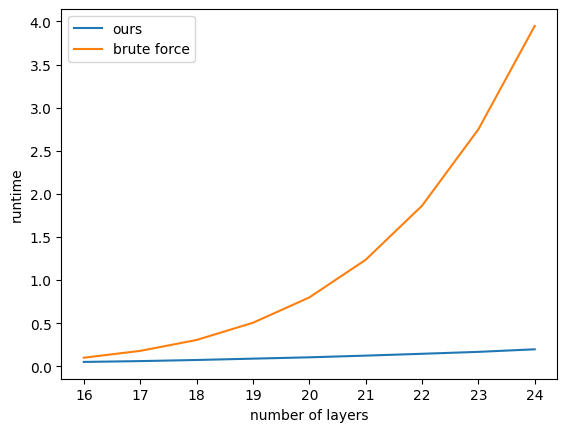

In [ ]:
plt.plot([16,17, 18, 19, 20, 21, 22, 23, 24], dp_time, label="ours")
plt.plot([16,17, 18, 19, 20, 21, 22, 23, 24], bf_time, label="brute force")
plt.xlabel("number of layers")
plt.ylabel("runtime")
plt.legend(loc="best")